In [13]:
import sys
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
from BSM_imp_vol import call_option
from CIR_zcb_valuation import B

mpl.rcParams['font.family'] = 'serif'

S0 = 3225.93  # EURO STOXX 50 level 30.09.2014
r0 = -0.00032
kappa_r, theta_r, sigma_r= 0.1468490095575928,0.1045105366734434,0.17519710713793513


In [14]:
def calculate_implied_volatilities(filename):
    ''' Calculates market and model implied volatilities. '''
    h5 = pd.HDFStore(filename, 'r')
    options = h5['options']
    h5.close()
    for row, option in options.iterrows():
        # T = (option['Maturity'] - option['Date']).days / 365.
        # B0T = B([kappa_r, theta_r, sigma_r, r0, T])
        # r = -math.log(B0T) / T
        call = call_option(S0, option['Strike'], option['Date'],
                           option['Maturity'], option['r'], 0.1)
        options.loc[row, 'market_iv'] = call.imp_vol(option['Call'], 0.15)
        options.loc[row, 'model_iv'] = call.imp_vol(option['Model'], 0.15)
    return options


def plot_implied_volatilities(options, model):
    ''' Plots market implied volatilities against model implied ones. '''
    global opts
    mats = sorted(set(options.Maturity))
    for mat in mats:
        opts = options[options.Maturity == mat]
        plt.figure(figsize=(8, 6))
        plt.subplot(211)
        plt.ylabel('implied volatility')
        plt.plot(opts.Strike, opts.market_iv, 'b', label='market', lw=1.5)
        plt.plot(opts.Strike, opts.model_iv, 'ro', label='model')
        plt.legend(loc=0)
        plt.axis([min(opts.Strike) - 10, max(opts.Strike) + 10,
                  min(opts.market_iv) - 0.015, max(opts.market_iv) + 0.015])
        plt.title('Maturity %s' % str(mat)[:10])
        plt.subplot(212)
        wi = 5.0
        diffs = opts.model_iv.values - opts.market_iv.values
        plt.bar(opts.Strike.values - wi / 2, diffs, width=wi)
        plt.ylabel('difference')
        ymi = min(diffs) - (max(diffs) - min(diffs)) * 0.1
        yma = max(diffs) + (max(diffs) - min(diffs)) * 0.1
        plt.axis([min(opts.Strike) - 10, max(opts.Strike) + 10, ymi, yma])
        plt.tight_layout()
        plt.savefig('%s_calibration_iv_%s.pdf'
                    % (model, str(mat)[:10]))


In [15]:
filename = 'cal_results_sv.h5'


In [16]:
options = calculate_implied_volatilities(filename)

In [17]:
# total net error
print(np.sum(options['model_iv'] - options['market_iv']))
# total absolute error
print(np.sum(abs(options['model_iv'] - options['market_iv'])))

-0.0013941380775854273
0.017388132037194803


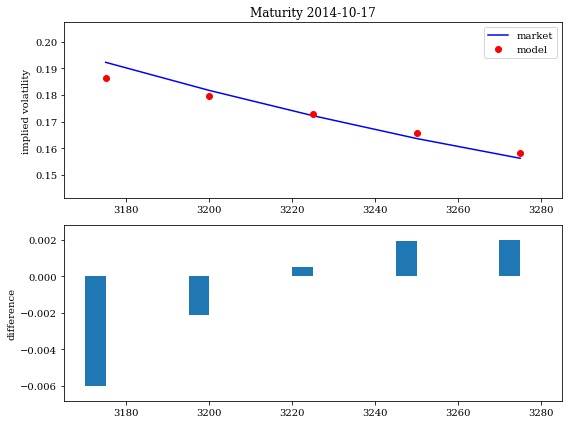

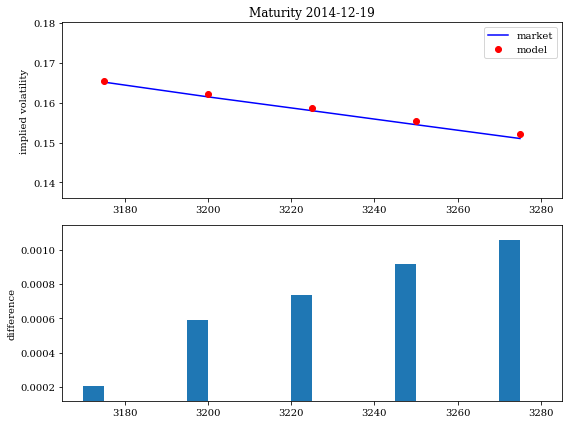

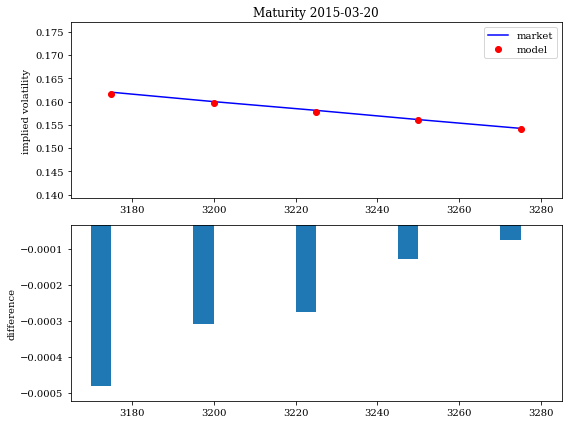

In [18]:
plot_implied_volatilities(options, 'H93')